In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data= pd.read_csv('/kaggle/input/language-translation-englishfrench/eng_-french.csv')
data

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


In [3]:
english_sentences = data["English words/sentences"].tolist()
french_sentences = data["French words/sentences"].tolist()

In [4]:
# Tokenize the English sentences
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(english_sentences)
eng_seq = tokenizer_eng.texts_to_sequences(english_sentences)

#Tokenize the french Sentences 
tokenizer_fr = Tokenizer()
tokenizer_fr.fit_on_texts(french_sentences)
fr_seq = tokenizer_fr.texts_to_sequences(french_sentences)


vocab_size_eng = len(tokenizer_eng.word_index) + 1
vocab_size_fr = len(tokenizer_fr.word_index) + 1

# applying the padding
max_length = max(len(seq) for seq in eng_seq + fr_seq)
eng_seq_padded = pad_sequences(eng_seq, maxlen=max_length, padding='post')
fr_seq_padded = pad_sequences(fr_seq, maxlen=max_length, padding='post')

In [5]:
embedding_dim = 256
units = 512

# Encoder
encoder_inputs = Input(shape=(max_length,))
enc_emb = Embedding(input_dim=vocab_size_eng, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(units, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_length,))
dec_emb_layer = Embedding(input_dim=vocab_size_fr, output_dim=embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_fr, activation='softmax')
output = decoder_dense(decoder_outputs)

# the model that connects the encoder and decoder
model = Model([encoder_inputs, decoder_inputs], output)

# Compile the model with an appropriate optimizer and loss function
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

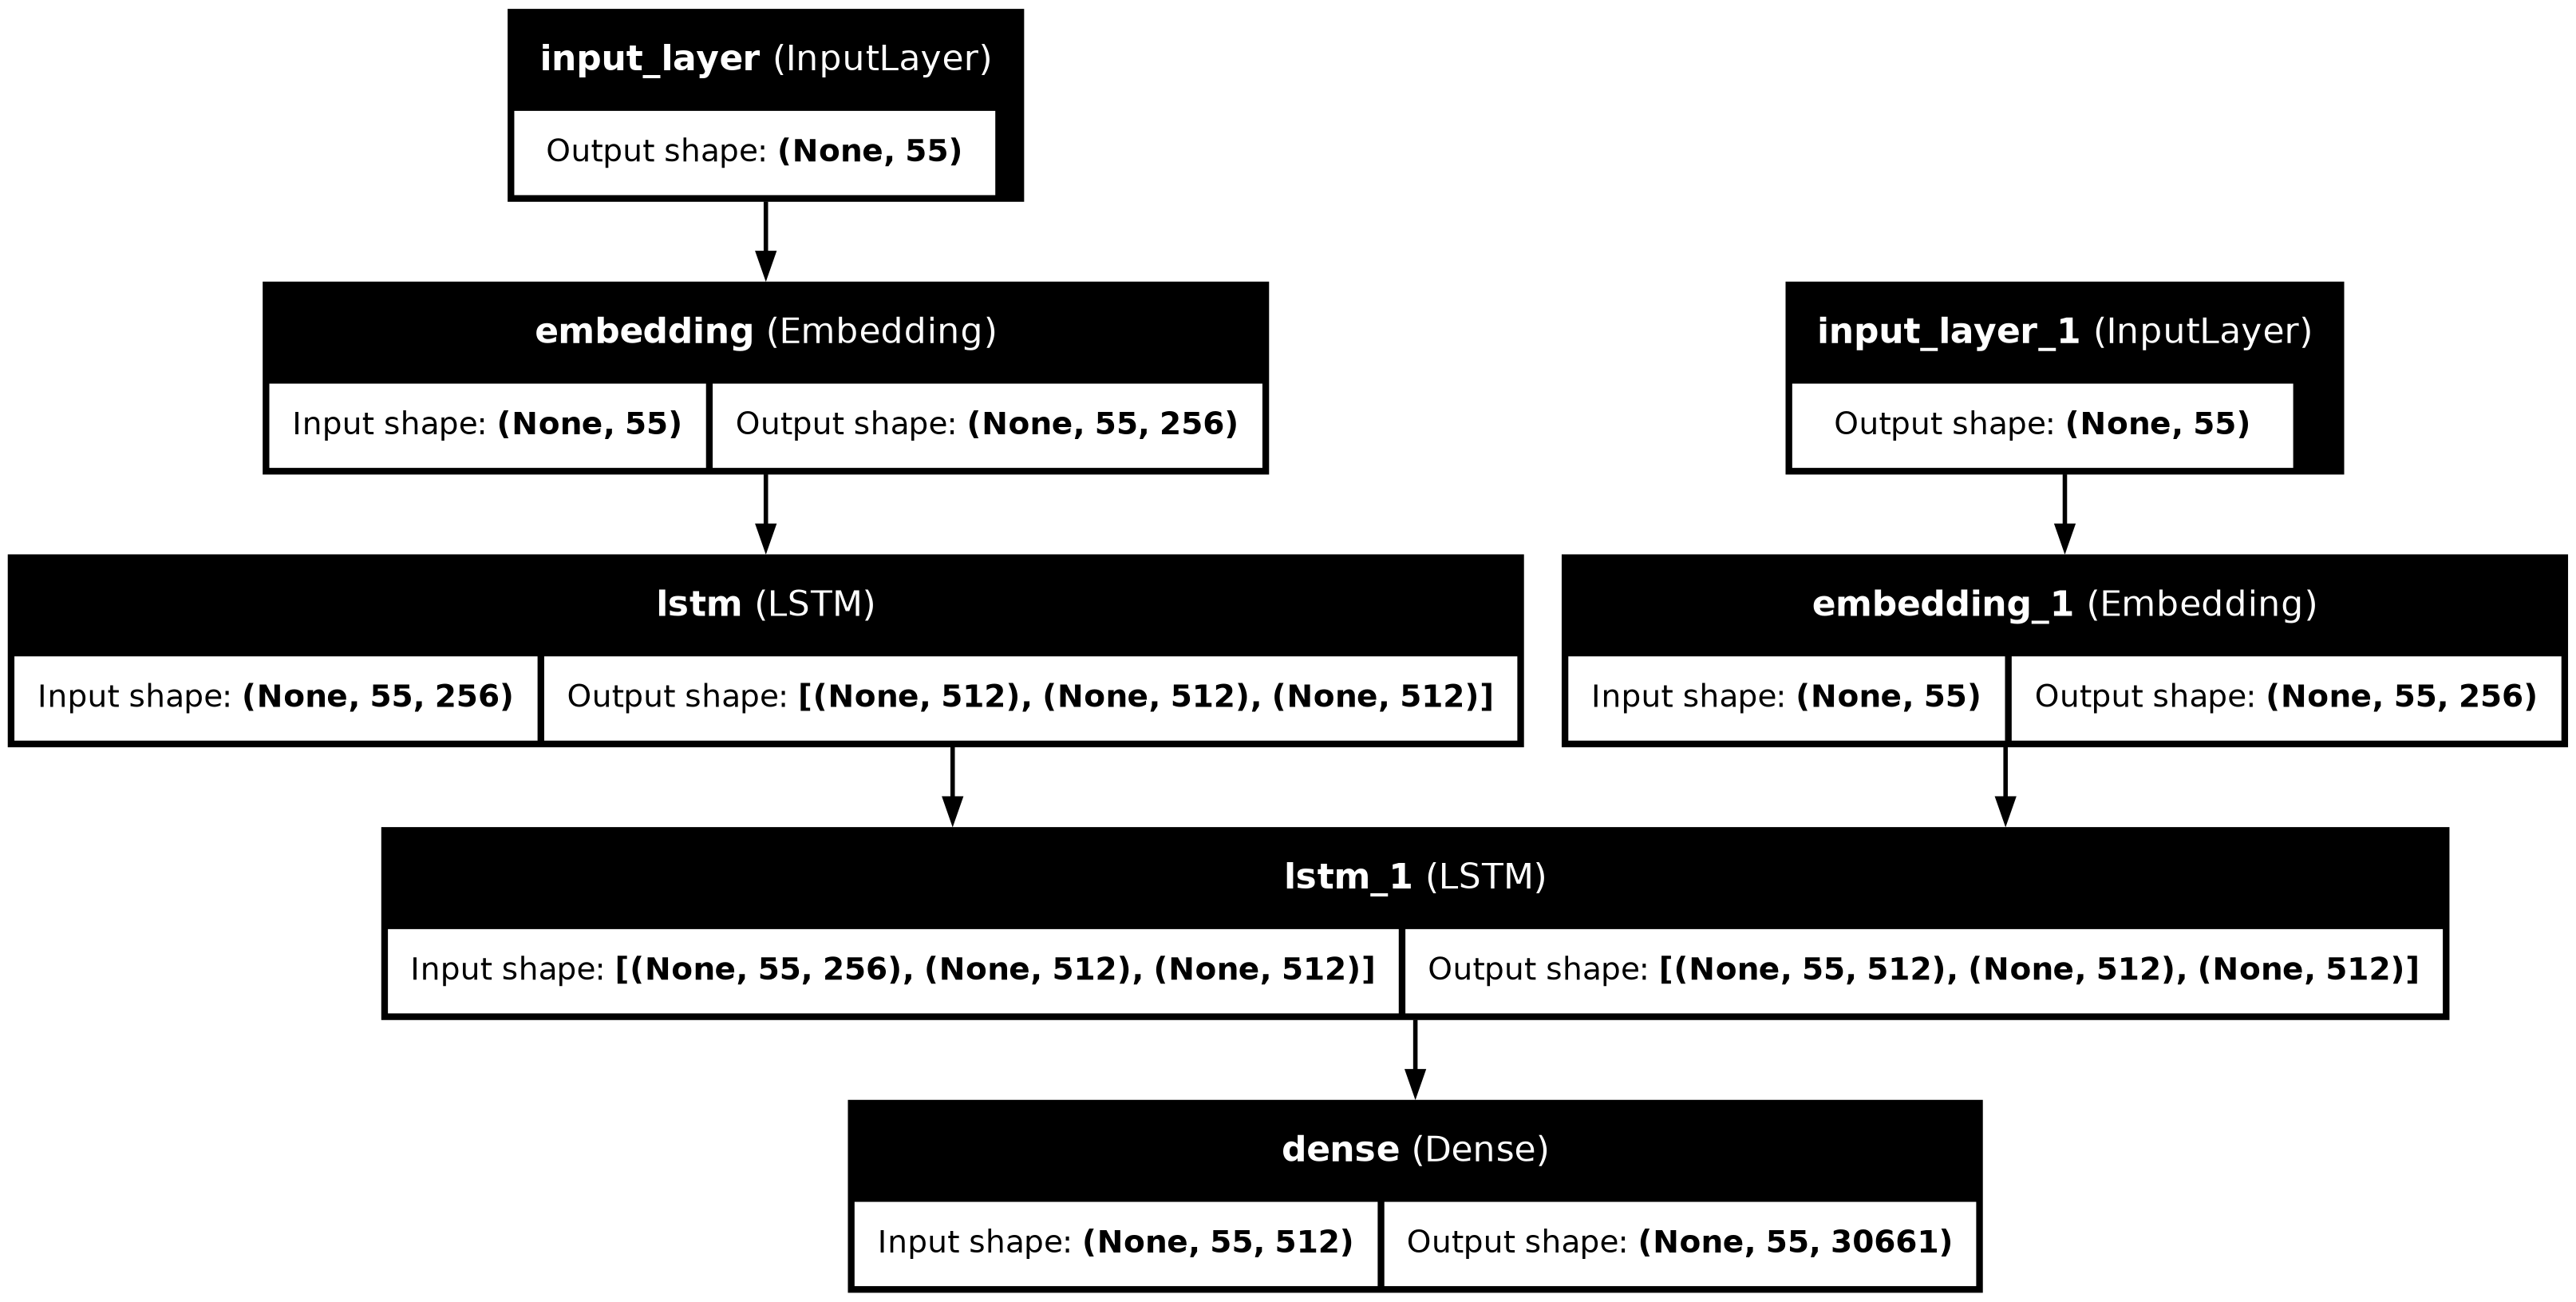

In [7]:
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [8]:
X_train, X_val, y_train, y_val = train_test_split(eng_seq_padded, fr_seq_padded, test_size=0.1)
history = model.fit([X_train, X_train], y_train, validation_data=([X_val, X_val], y_val), epochs=6, batch_size=64)

Epoch 1/6
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 500s 201ms/step - accuracy: 0.8855 - loss: 1.0084 - val_accuracy: 0.9057 - val_loss: 0.6110
Epoch 2/6
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 496s 201ms/step - accuracy: 0.9097 - loss: 0.5569 - val_accuracy: 0.9151 - val_loss: 0.4854
Epoch 3/6
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 496s 201ms/step - accuracy: 0.9186 - loss: 0.4310 - val_accuracy: 0.9200 - val_loss: 0.4369
Epoch 4/6
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 496s 201ms/step - accuracy: 0.9246 - loss: 0.3599 - val_accuracy: 0.9223 - val_loss: 0.4160
Epoch 5/6
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 497s 201ms/step - accuracy: 0.9299 - loss: 0.3125 - val_accuracy: 0.9238 - val_loss: 0.4075
Epoch 6/6
2470/2470 ━━━━━━━━━━━━━━━━━━━━ 498s 201ms/step - accuracy: 0.9344 - loss: 0.2804 - val_accuracy: 0.9247 - val_loss: 0.4055


In [9]:
loss, accuracy = model.evaluate([X_val, X_val], y_val)


549/549 ━━━━━━━━━━━━━━━━━━━━ 48s 88ms/step - accuracy: 0.9248 - loss: 0.4034


In [10]:
print("The overall Accuracy: ")
print(accuracy)

The overall Accuracy: 
0.9246649146080017


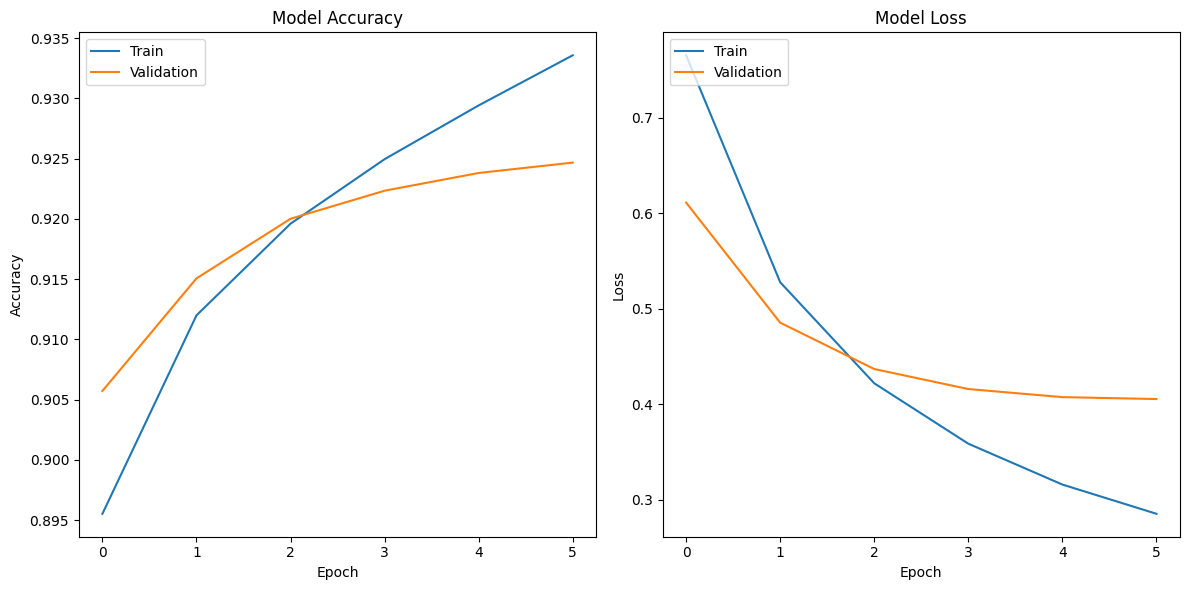

In [11]:
# Plotting training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plotting training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Display the plots
plt.tight_layout()
plt.show()

In [16]:
def translate_sentence(sentence):
    seq = tokenizer_eng.texts_to_sequences([sentence])
    padded = pad_sequences(seq, maxlen=max_length, padding='post')
    translated = np.argmax(model.predict([padded, padded]), axis=-1)
    
    translated_sentence = []
    for i in translated[0]:
        if i in tokenizer_fr.index_word:
            translated_sentence.append(tokenizer_fr.index_word[i])
        else:
            translated_sentence.append(' ') 
            
            
    return ' '.join(translated_sentence)

In [23]:
input_sentence = "my name is eslam"
translated_sentence = translate_sentence(input_sentence)
print(f"Input: {input_sentence}")
print(f"Translated: {translated_sentence}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Input: my name is eslam
Translated: mon m'appelle est                                                                                                        
